# Proyek Klasifikasi Gambar: Rice Image Dataset

- **Nama:** Frederick Godiva
- **Email:** godivafrederick@gmail.com
- **ID Dicoding:** frederickgodiva


## Import Libraries


In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, Callback

## Data Preparation


### Data Loading


In [6]:
base_dir = './Rice_Image_Dataset'
categories = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [ ]:
path_sub = "./Rice_Image_Dataset/"
num_images_per_class = 5

rice_images = {
    class_name: os.listdir(os.path.join(path_sub, class_name))
    for class_name in os.listdir(path_sub)
    if os.path.isdir(os.path.join(path_sub, class_name))
}

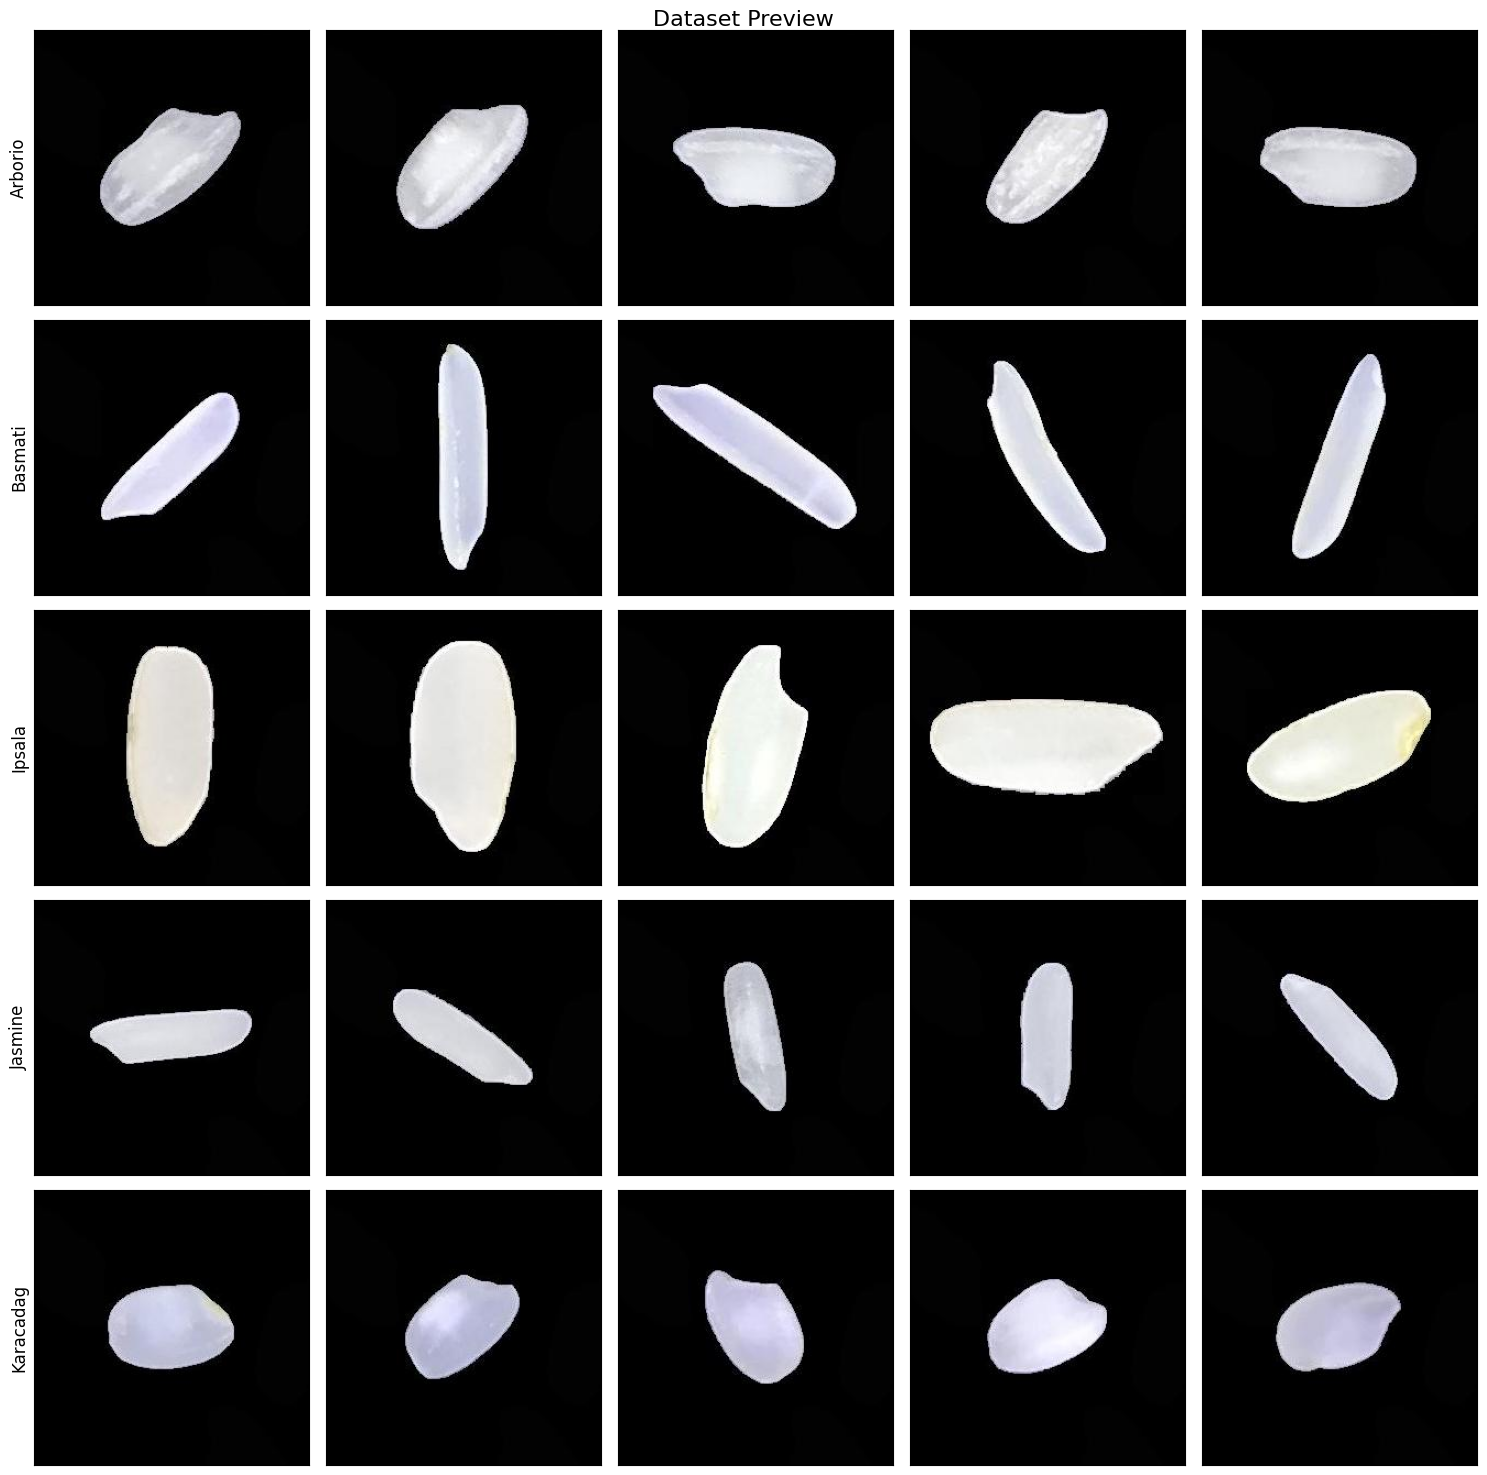

In [ ]:
fig, axs = plt.subplots(len(rice_images), num_images_per_class, figsize=(
    num_images_per_class * 3, len(rice_images) * 3))

for i, (class_name, image_list) in enumerate(rice_images.items()):
    selected_images = np.random.choice(
        image_list, num_images_per_class, replace=False)

    for j, image_name in enumerate(selected_images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xticks=[], yticks=[])
        if j == 0:
            axs[i, j].set_ylabel(class_name, fontsize=12)


fig.suptitle("Dataset Preview", fontsize=16)
fig.tight_layout()
plt.show()

### Data Preprocessing


#### Split Dataset


In [ ]:
image_dir = './img'
train_dir = os.path.join(image_dir, 'train')
test_dir = os.path.join(image_dir, 'test')
val_dir = os.path.join(image_dir, 'val')

In [ ]:
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

In [ ]:
for category in categories:
    category_dir = os.path.join(base_dir, category)
    images = os.listdir(category_dir)

    temp_images, test_images = train_test_split(
        images, test_size=0.1, random_state=42)

    train_images, val_images = train_test_split(
        temp_images, test_size=0.2, random_state=42)

    train_category_dir = os.path.join(train_dir, category)
    val_category_dir = os.path.join(val_dir, category)
    test_category_dir = os.path.join(test_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(val_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)

    for image in train_images:
        shutil.copy(os.path.join(category_dir, image),
                    os.path.join(train_category_dir, image))

    for image in val_images:
        shutil.copy(os.path.join(category_dir, image),
                    os.path.join(val_category_dir, image))

    for image in test_images:
        shutil.copy(os.path.join(category_dir, image),
                    os.path.join(test_category_dir, image))

## Modelling


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(24, 24),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(24, 24),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(24, 24),
    batch_size=64,
    class_mode='categorical',
)

Found 54000 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.
Found 13500 images belonging to 5 classes.


In [ ]:
def build_model(hp):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu',
               padding='same', input_shape=(24, 24, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        GlobalAveragePooling2D(),

        Dense(hp.Int('units', min_value=64,
              max_value=256, step=32), activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-4, 5e-4, 1e-3])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=5,
    directory='tuner_directory',
    project_name='rice_image_classification'
)

d:\Learn\Dicoding\Belajar Pengembangan Machine Learning\11 - Proyek Klasifikasi Gambar\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
class val_accuracy_Callback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') >= 0.96:
            self.model.stop_training = True


accuracy_stopping = val_accuracy_Callback()

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_generator, epochs=20, verbose=1,
             validation_data=val_generator, callbacks=[early_stopping, accuracy_stopping])

Trial 13 Complete [00h 20m 08s]
val_accuracy: 0.9015555381774902

Best val_accuracy So Far: 0.979629635810852
Total elapsed time: 02h 05m 55s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

d:\Learn\Dicoding\Belajar Pengembangan Machine Learning\11 - Proyek Klasifikasi Gambar\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Learn\Dicoding\Belajar Pengembangan Machine Learning\11 - Proyek Klasifikasi Gambar\venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │        49,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320,017 (5.04 MB)

 Trainable params: 439,685 (1.68 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 879,372 (3.35 MB)

In [ ]:
history = best_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.9932 - loss: 0.0215 - val_accuracy: 0.9387 - val_loss: 0.2231
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 79s 94ms/step - accuracy: 0.9931 - loss: 0.0212 - val_accuracy: 0.9451 - val_loss: 0.2005
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 79s 94ms/step - accuracy: 0.9937 - loss: 0.0207 - val_accuracy: 0.9128 - val_loss: 0.2739
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 93s 111ms/step - accuracy: 0.9912 - loss: 0.0267 - val_accuracy: 0.8584 - val_loss: 0.6101
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 101s 120ms/step - accuracy: 0.9944 - loss: 0.0175 - val_accuracy: 0.9921 - val_loss: 0.0251
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 84s 100ms/step - accuracy: 0.9945 - loss: 0.0189 - val_accuracy: 0.9751 - val_loss: 0.0903
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 120s 143ms/step - accuracy: 0.9936 - loss: 0.0203 - val_accuracy: 0.9044 - val_loss: 0.3409
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 99s 117ms/step - accuracy: 0.9936 - loss: 0.

## Evaluation and Visualization


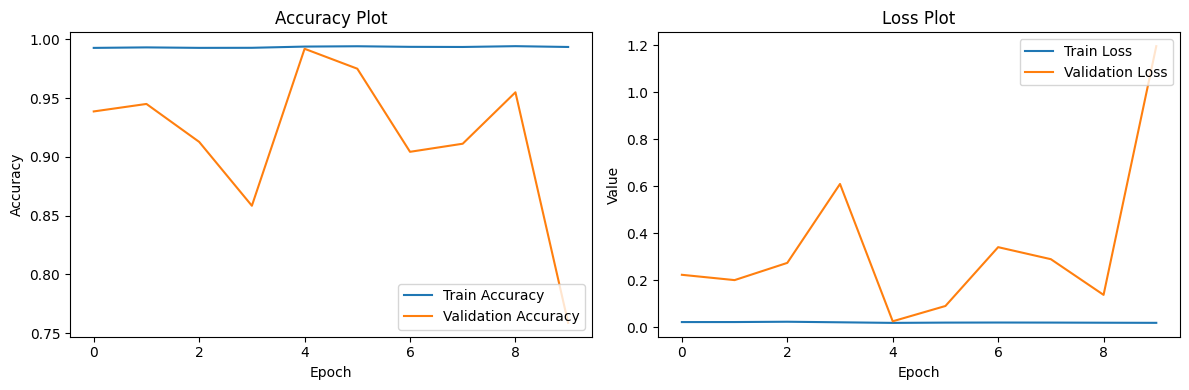

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Accuracy Plot')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right')

ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Loss Plot')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Value')
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
class_labels = list(test_generator.class_indices.keys())
y_true = test_generator.classes

In [ ]:
y_pred = best_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


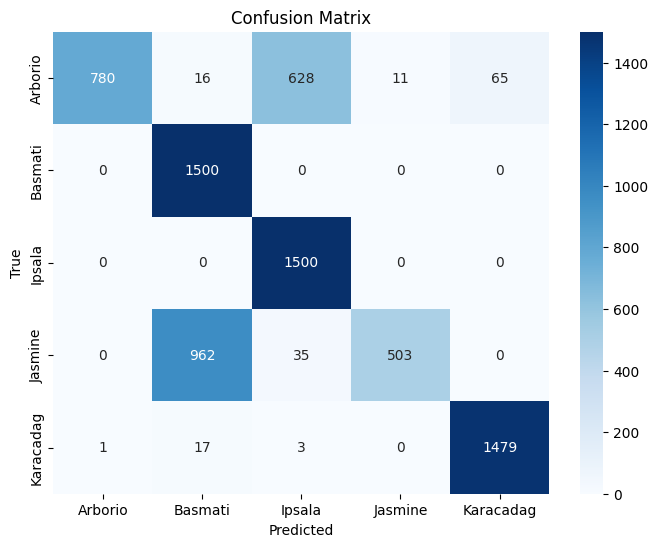

Classification Report:
              precision    recall  f1-score   support

     Arborio       1.00      0.52      0.68      1500
     Basmati       0.60      1.00      0.75      1500
      Ipsala       0.69      1.00      0.82      1500
     Jasmine       0.98      0.34      0.50      1500
   Karacadag       0.96      0.99      0.97      1500

    accuracy                           0.77      7500
   macro avg       0.85      0.77      0.74      7500
weighted avg       0.85      0.77      0.74      7500



In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

## Model Convertion


### SavedModel Format


In [ ]:
best_model.save("model.keras")

In [6]:
model = tf.keras.models.load_model('model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
model.export('./saved_model')

Saved artifact at './saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 24, 24, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  135467335465680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467335466832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320659216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320659024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320658448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320659408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320659984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320660368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320662864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320661904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320662672: Ten

### TensorFlow.js Format


In [8]:
!tensorflowjs_converter --input_format=tf_saved_model ./saved_model ./tfjs_model

2025-04-24 13:31:59.716221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745501519.741907    2168 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745501519.749363    2168 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-24 13:32:04.968881: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1745501525.159762    2168 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

### TensorFlow Lite Format


In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmphii229tp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 24, 24, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  135467335465680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467335466832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320659216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320659024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320658448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320659408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320659984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320660368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320662864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320661904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135467320662672: 

In [16]:
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

1765888

## Inference


In [3]:
model = tf.keras.models.load_model('model.keras')

d:\Learn\Dicoding\Belajar Pengembangan Machine Learning\11 - Proyek Klasifikasi Gambar\venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


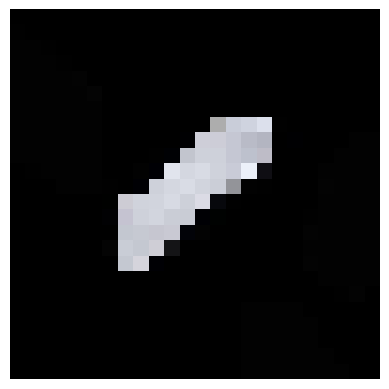

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediksi: Jasmine


In [13]:
img_path = r"./img/test/Jasmine/Jasmine (158).jpg"
img = load_img(img_path, target_size=(24, 24))

plt.imshow(img)
plt.axis('off')
plt.show()

x = img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)

classes = model.predict(x)
output = np.argmax(classes)

print(f"Prediksi: {categories[output]}")